## Health
### Introduction
嗯嗯.

### Libraries & Settings

In [105]:
import os
import warnings

import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.neural_network import MLPRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error, r2_score

import statsmodels.api as sm

import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
# %matplotlib notebook

### Data

#### Data Preparation

In [106]:
train_data_percentage = 0.8
train_data_path = 'train_data.csv'
test_data_path = 'test_data.csv'

if os.path.exists(train_data_path) and os.path.exists(test_data_path):
    dataset_train = pd.read_csv(train_data_path)
    dataset_test = pd.read_csv(test_data_path)
else:
    # Parameters & Functions
    selected_country_codes = ['GBR', 'FRA', 'DEU', 'ITA', 'NLD', 'NOR', 'SWE', 'FIN', 'DNK', 'ISL', 'CHE', 'BEL', 'LUX', 'IRL', 'ESP', 'PRT', 'AUT', 'CZE', 'SVK', 'HUN', 'GRC', 'SVN', 'POL', 'EST', 'LVA', 'LTU', 'MLT', 'CYP'] # , 'SMR'
    selected_year_codes = list(map(str, range(2010, 2023 + 1)))

    def select_dataframe(data_frame):
        return data_frame[data_frame['Country Code'].isin(selected_country_codes)].iloc[:, :-1].reset_index(drop = True)

    def organize_dataframe(data_frame, value_name):
        res = pd.melt(data_frame, id_vars = ['Country Name', 'Country Code', 'Indicator Name', 'Indicator Code'], var_name = 'Year Code', value_name = value_name)[['Country Code', 'Year Code', value_name]]
        res[value_name] = res.groupby('Country Code')[value_name].ffill().bfill()
        return res[res['Year Code'].isin(selected_year_codes)]

    # Load .csv files
    csv_path = '../data/'

    alcohol_csv = select_dataframe(pd.read_csv(os.path.join(csv_path, 'alcohol_consumption_per_capita.csv'))) # Liter of pure alcohol per capita
    alcohol_male_csv = select_dataframe(pd.read_csv(os.path.join(csv_path, 'alcohol_consumption_per_capita_male.csv'))) # Liter of pure alcohol per capita, male
    alcohol_female_csv = select_dataframe(pd.read_csv(os.path.join(csv_path, 'alcohol_consumption_per_capita_female.csv'))) # Liter of pure alcohol per capita, female
    tobacco_csv = select_dataframe(pd.read_csv(os.path.join(csv_path, 'prevalence_of_current_tobacco_use.csv'))) # % of adults
    tobacco_male_csv = select_dataframe(pd.read_csv(os.path.join(csv_path, 'prevalence_of_current_tobacco_use_male.csv'))) # % of male adults
    tobacco_female_csv = select_dataframe(pd.read_csv(os.path.join(csv_path, 'prevalence_of_current_tobacco_use_female.csv'))) # % of female adults

    diabetes_csv = select_dataframe(pd.read_csv(os.path.join(csv_path, 'diabetes_prevalence.csv'))) # % of population ages 20 to 79
    tuberculosis_csv = select_dataframe(pd.read_csv(os.path.join(csv_path, 'incidence_of_tuberculosis.csv'))) # per 100,000 people
    mortality_specified_csv = select_dataframe(pd.read_csv(os.path.join(csv_path, 'mortality_from_CVD_cancer_diabetes_CRD.csv'))) # % of population ages 30 and 70
    mortality_specified_male_csv = select_dataframe(pd.read_csv(os.path.join(csv_path, 'mortality_from_CVD_cancer_diabetes_CRD_male.csv'))) # % of male population ages 30 and 70
    mortality_specified_female_csv = select_dataframe(pd.read_csv(os.path.join(csv_path, 'mortality_from_CVD_cancer_diabetes_CRD_female.csv'))) # % of female population ages 30 and 70

    # Organize data
    alcohol_df = organize_dataframe(alcohol_csv, 'alcohol') # Alcohol Consumption
    merged_df = alcohol_df

    alcohol_male_df = organize_dataframe(alcohol_male_csv, 'alcohol_m') # Alcohol Consumption (M)
    merged_df = pd.merge(merged_df, alcohol_male_df, on = ['Country Code', 'Year Code'], how = 'outer')

    alcohol_female_df = organize_dataframe(alcohol_female_csv, 'alcohol_f') # Alcohol Consumption (F)
    merged_df = pd.merge(merged_df, alcohol_female_df, on = ['Country Code', 'Year Code'], how = 'outer')

    tobacco_df = organize_dataframe(tobacco_csv, 'tobacco') # Tobacco Use
    merged_df = pd.merge(merged_df, tobacco_df, on = ['Country Code', 'Year Code'], how = 'outer')

    tobacco_male_df = organize_dataframe(tobacco_male_csv, 'tobacco_m') # Tobacco Use (M)
    merged_df = pd.merge(merged_df, tobacco_male_df, on = ['Country Code', 'Year Code'], how = 'outer')

    tobacco_female_df = organize_dataframe(tobacco_female_csv, 'tobacco_f') # Tobacco Use (F)
    merged_df = pd.merge(merged_df, tobacco_female_df, on = ['Country Code', 'Year Code'], how = 'outer')

    diabetes_df = organize_dataframe(diabetes_csv, 'diabetes') # Diabetes Prevalence
    merged_df = pd.merge(merged_df, diabetes_df, on = ['Country Code', 'Year Code'], how = 'outer')

    tuberculosis_df = organize_dataframe(tuberculosis_csv, 'tuberculosis') # Tuberculosis Incidence
    merged_df = pd.merge(merged_df, tuberculosis_df, on = ['Country Code', 'Year Code'], how = 'outer')

    mortality_specified_df = organize_dataframe(mortality_specified_csv, 'mortality') # Mortality (Specified Types)
    merged_df = pd.merge(merged_df, mortality_specified_df, on = ['Country Code', 'Year Code'], how = 'outer')

    mortality_specified_male_df = organize_dataframe(mortality_specified_male_csv, 'mortality_m') # Mortality (Specified Types, M)
    merged_df = pd.merge(merged_df, mortality_specified_male_df, on = ['Country Code', 'Year Code'], how = 'outer')

    mortality_specified_female_df = organize_dataframe(mortality_specified_female_csv, 'mortality_f') # Mortality (Specified Types, F)
    merged_df = pd.merge(merged_df, mortality_specified_female_df, on = ['Country Code', 'Year Code'], how = 'outer')

    merged_df = merged_df.drop(columns = ['Country Code', 'Year Code']).dropna().reset_index(drop = True)
    
    # Divide into train and test data
    dataset_train, dataset_test = train_test_split(merged_df, test_size = 1 - train_data_percentage, random_state = 42)
    dataset_train = dataset_train.reset_index(drop = True)
    dataset_test = dataset_test.reset_index(drop = True)
    dataset_train.to_csv(train_data_path, index = False)
    dataset_test.to_csv(test_data_path, index = False)

# Add sex column and substitute total values
def add_sex_dummy_variable(dataset):
    rows = []
    for i, row in dataset.iterrows():
        rows.append({'alcohol': row['alcohol_m'], 'tobacco': row['tobacco_m'], 'sex': 0, 'diabetes': row['diabetes'], 'tuberculosis': row['tuberculosis'], 'mortality': row['mortality_m']})
        rows.append({'alcohol': row['alcohol_f'], 'tobacco': row['tobacco_f'], 'sex': 1, 'diabetes': row['diabetes'], 'tuberculosis': row['tuberculosis'], 'mortality': row['mortality_f']})
    return pd.DataFrame(rows)

dataset_train_mf = add_sex_dummy_variable(dataset_train)
dataset_test_mf = add_sex_dummy_variable(dataset_test)

#### Testing the Data

##### Correlation Matrix

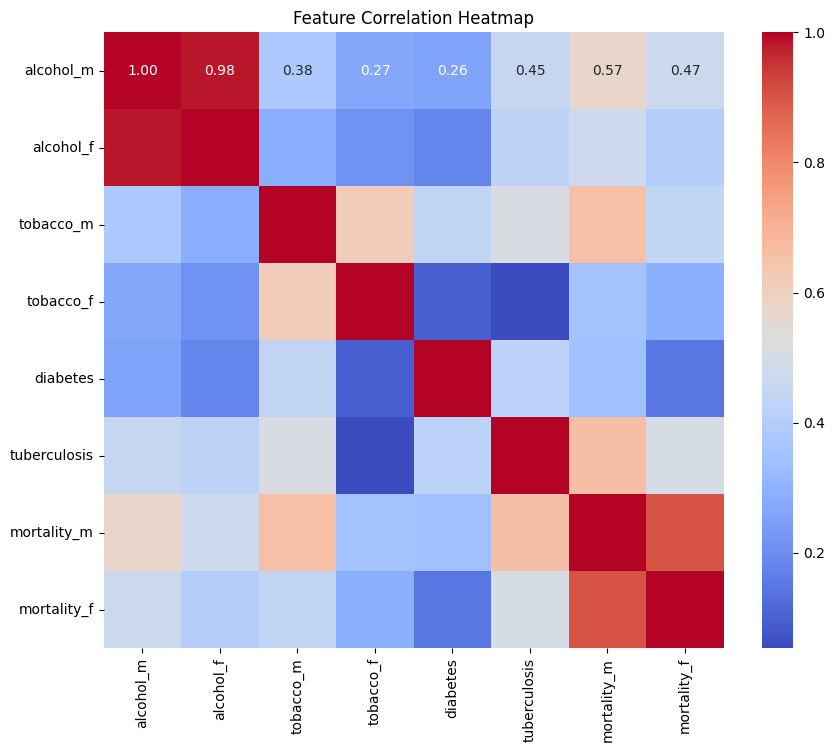

In [107]:
# plt.figure(figsize = (10, 8))
# sns.heatmap(dataset_train.drop(columns = ['alcohol_m', 'alcohol_f', 'tobacco_m', 'tobacco_f', 'mortality_m', 'mortality_f']).corr(), annot = True, cmap = 'coolwarm', fmt = '.2f')
# plt.title('Feature Correlation Heatmap')
# plt.show()

# plt.figure(figsize = (10, 8))
# sns.heatmap(dataset_train.corr(), annot = True, cmap = 'coolwarm', fmt = '.2f')
# plt.title('Feature Correlation Heatmap')
# plt.show()

plt.figure(figsize = (10, 8))
sns.heatmap(dataset_train.drop(columns = ['alcohol', 'tobacco', 'mortality']).corr(), annot = True, cmap = 'coolwarm', fmt = '.2f')
plt.title('Feature Correlation Heatmap')
plt.show()

TODO: 发现分性别后数据的相关性提高，故添加 sex 字段，0 为 male，1 为 female，重新整理数据集（见前 Data Preparation）。

##### Pairplot

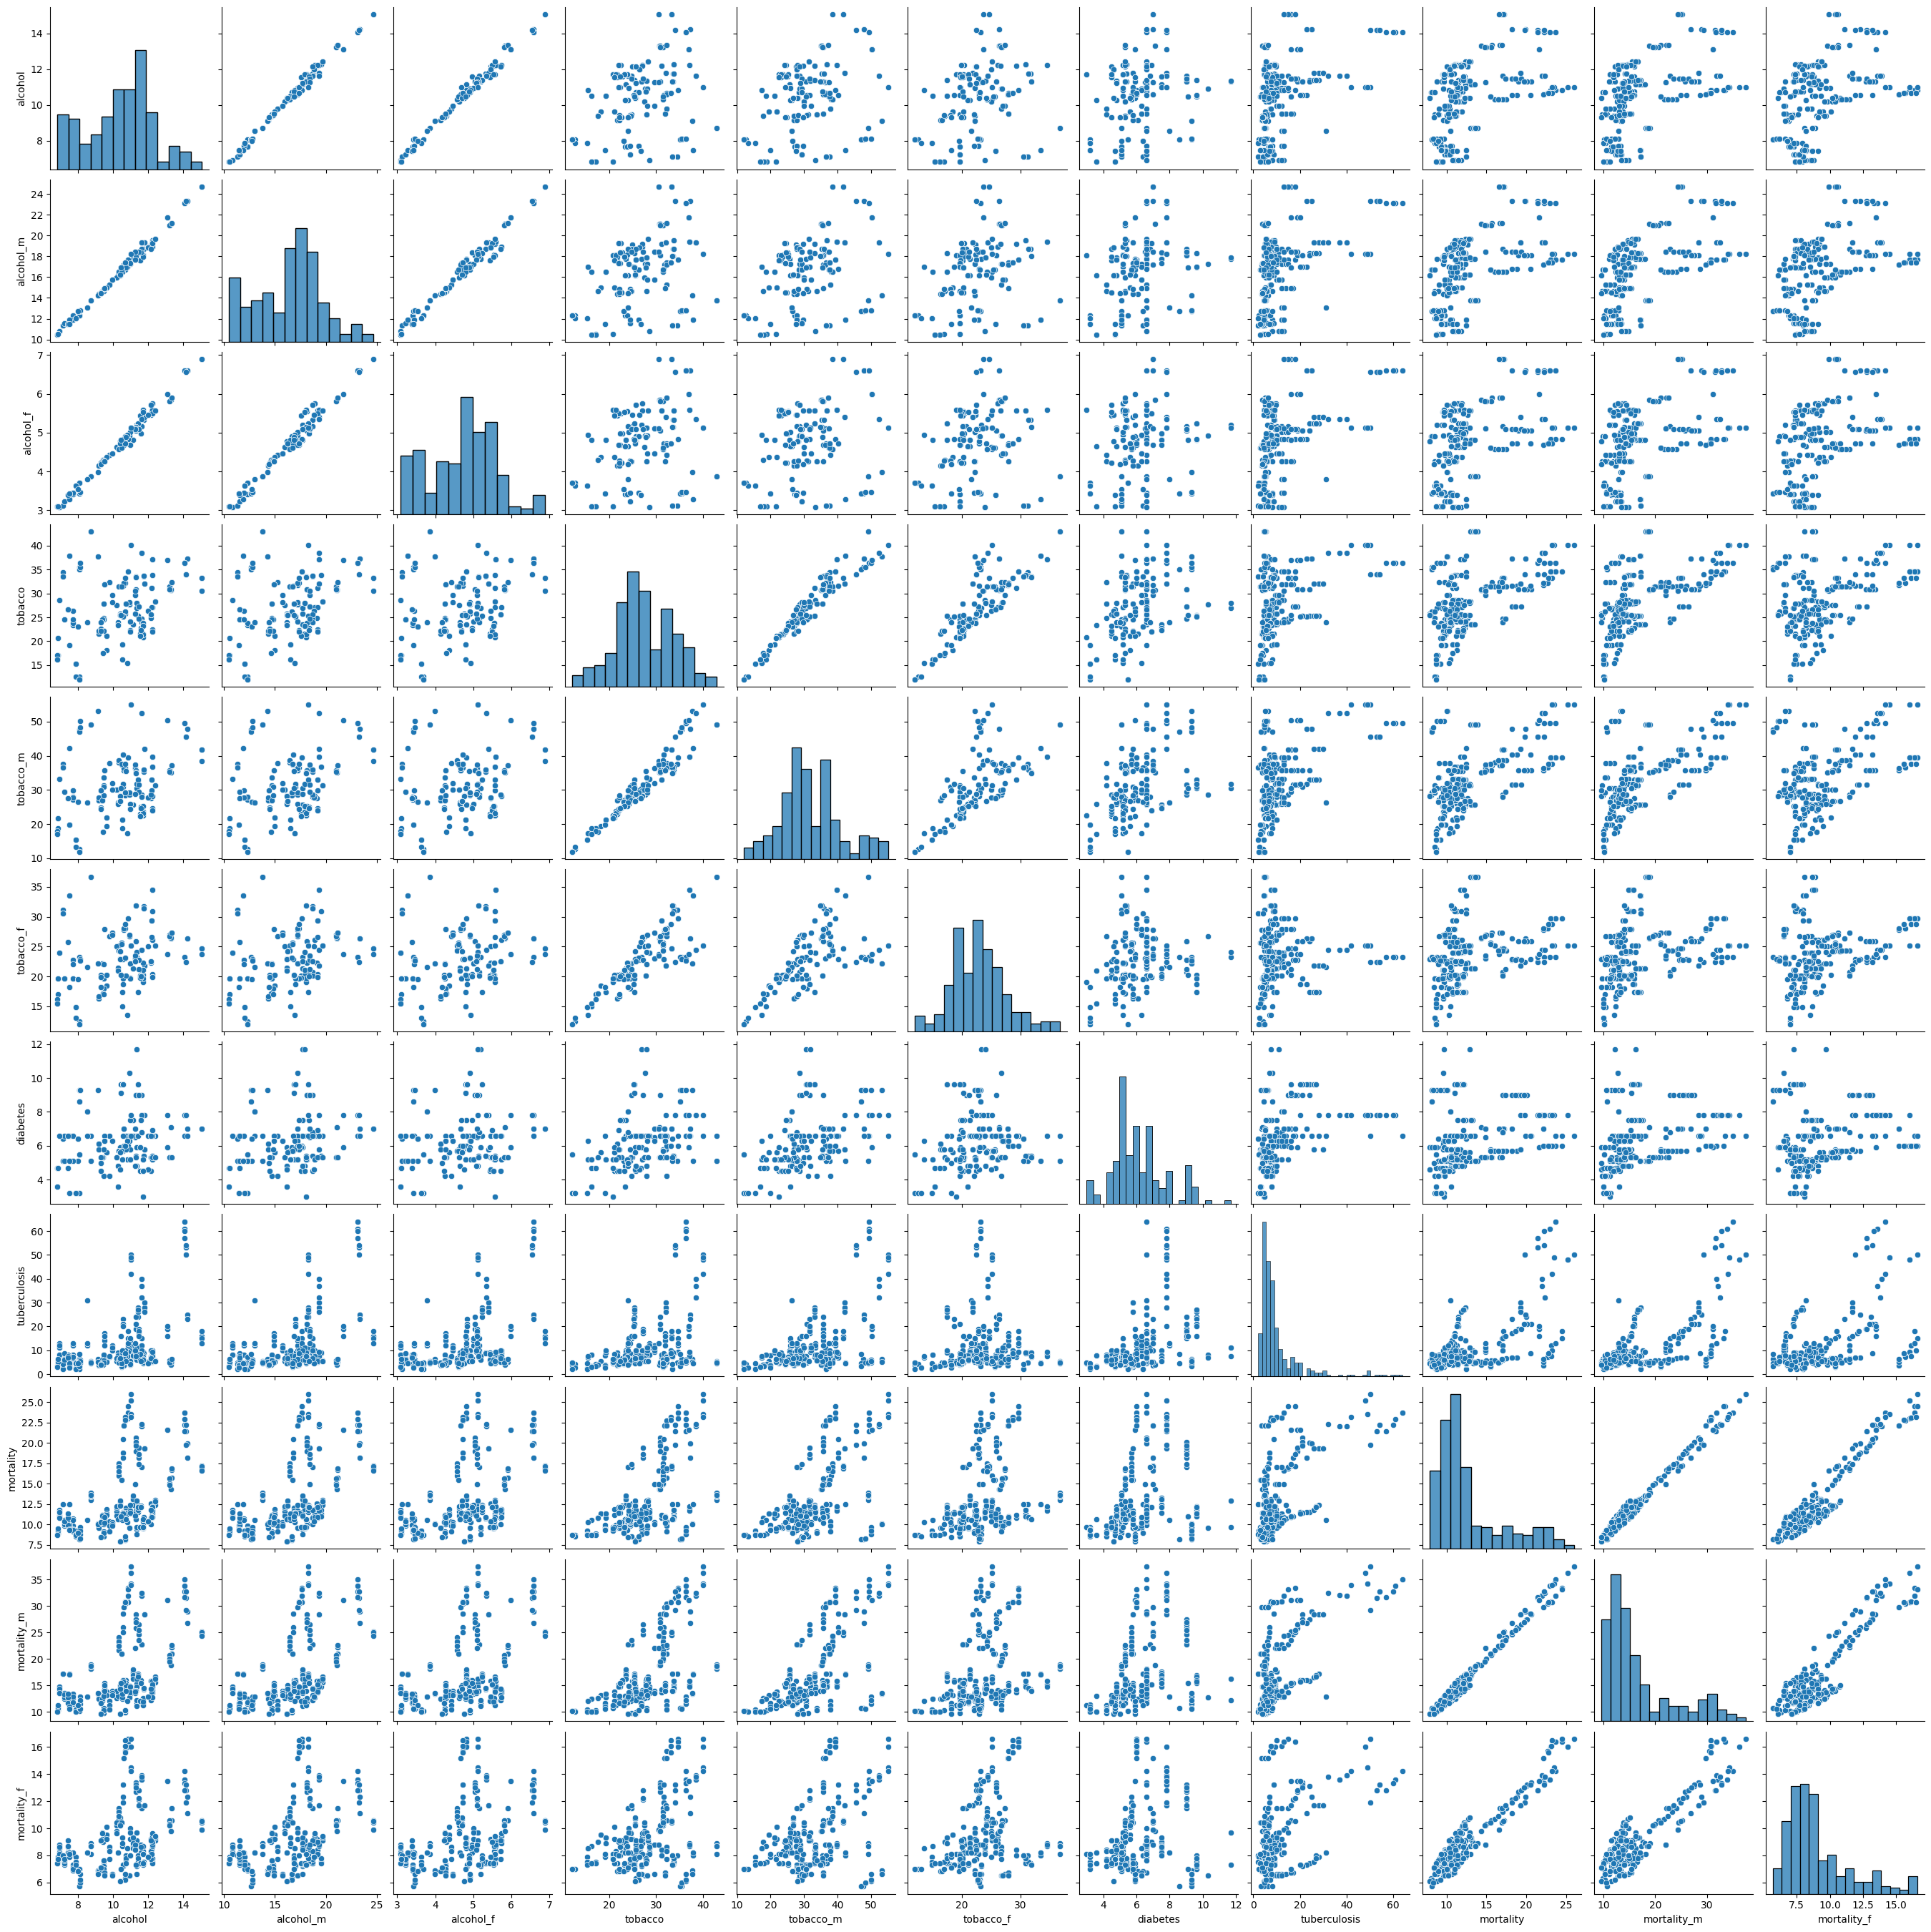

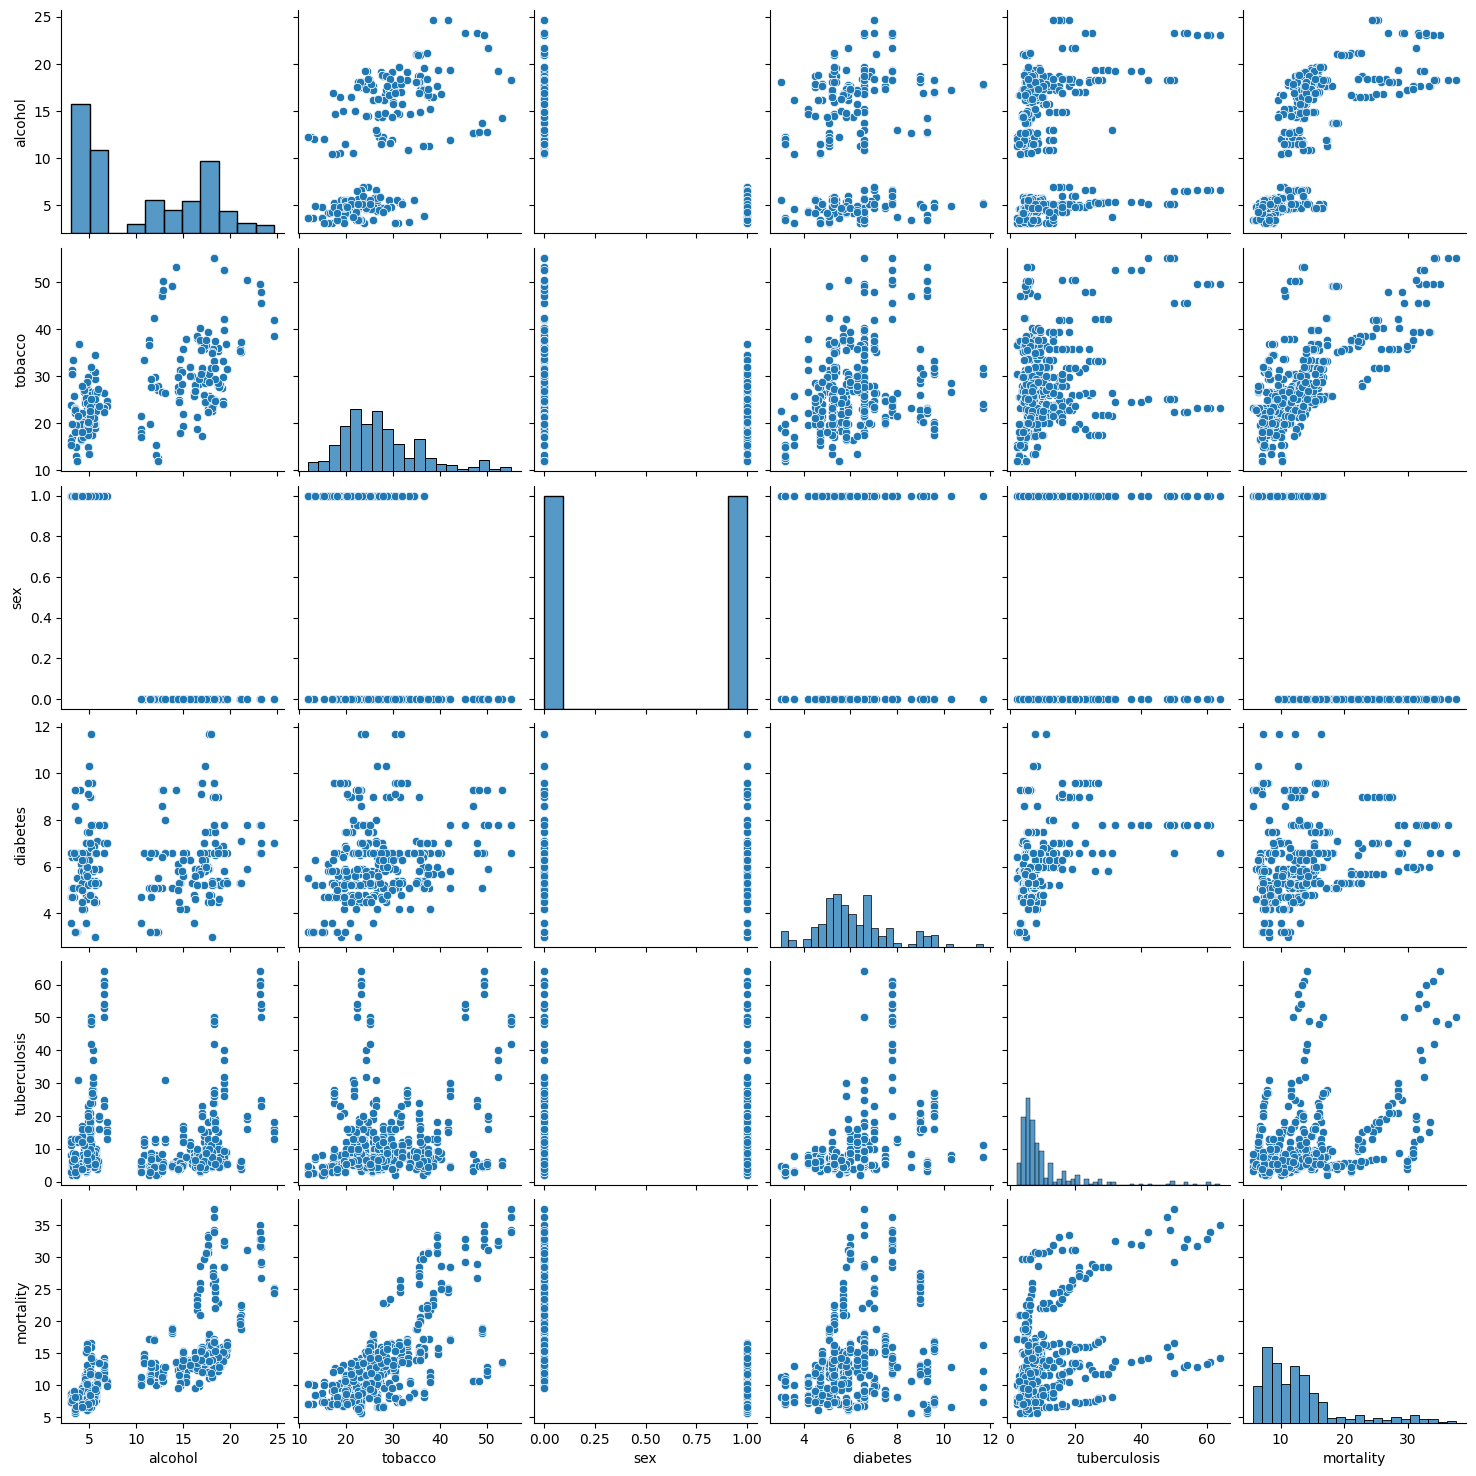

In [108]:
with warnings.catch_warnings():
    warnings.simplefilter('ignore', category = Warning)
    
    # sns.pairplot(dataset_train.drop(columns = ['alcohol_m', 'alcohol_f', 'tobacco_m', 'tobacco_f', 'mortality_m', 'mortality_f']))
    # plt.show()

    # sns.pairplot(dataset_train.drop(columns = ['alcohol', 'tobacco', 'mortality']))
    # plt.show()

    sns.pairplot(dataset_train)
    plt.show()

    sns.pairplot(dataset_train_mf)
    plt.show()

### 糖尿病、结核病发病率，与饮酒、吸烟、性别的关系

#### Multiple Linear Regression

                            OLS Regression Results                            
Dep. Variable:               diabetes   R-squared:                       0.118
Model:                            OLS   Adj. R-squared:                  0.111
Method:                 Least Squares   F-statistic:                     16.66
Date:                Sun, 26 May 2024   Prob (F-statistic):           1.86e-15
Time:                        19:36:28   Log-Likelihood:                -1135.1
No. Observations:                 626   AIC:                             2282.
Df Residuals:                     620   BIC:                             2309.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const             3.0429      0.467      6.516

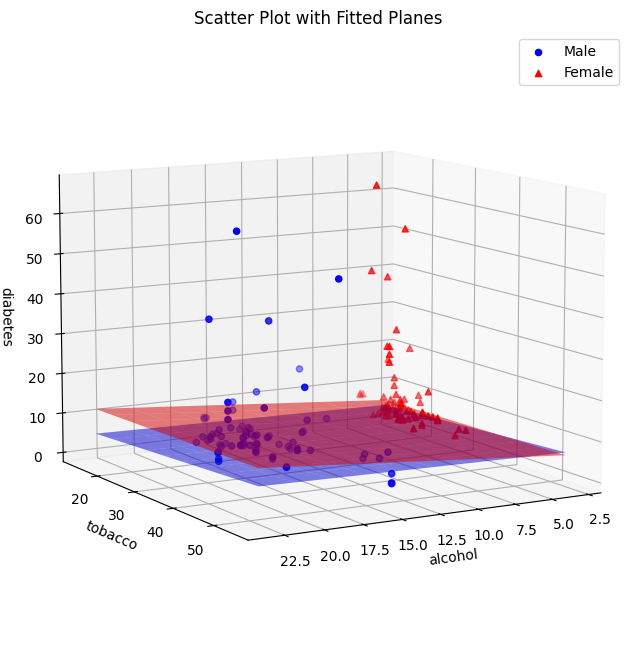

                            OLS Regression Results                            
Dep. Variable:           tuberculosis   R-squared:                       0.261
Model:                            OLS   Adj. R-squared:                  0.255
Method:                 Least Squares   F-statistic:                     43.74
Date:                Sun, 26 May 2024   Prob (F-statistic):           1.18e-38
Time:                        19:36:28   Log-Likelihood:                -2255.5
No. Observations:                 626   AIC:                             4523.
Df Residuals:                     620   BIC:                             4550.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const           -20.1350      2.796     -7.200

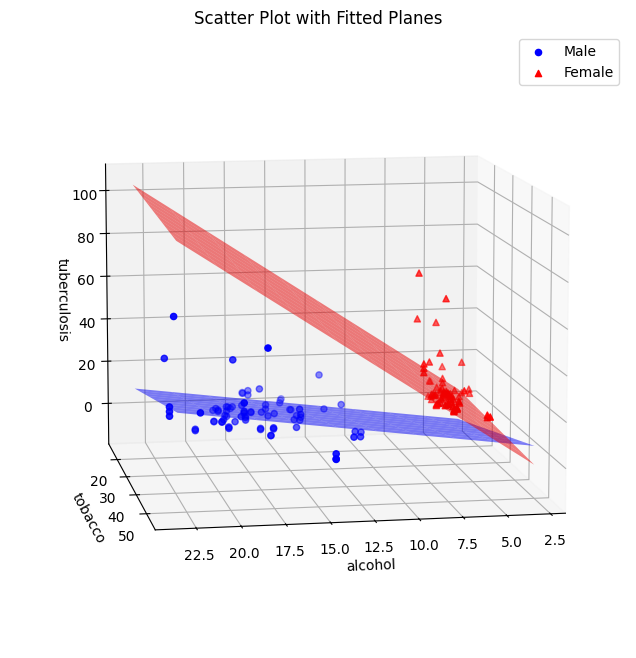

In [114]:
def mlr_process(y_name = 'diabetes', elev = 10, azim = 80, plot_dataset_source = 'test'):
    plot_dataset = dataset_test_mf if plot_dataset_source == 'test' else dataset_train_mf
    
    # Prepare data
    X_train = dataset_train_mf[['alcohol', 'tobacco', 'sex']].copy()
    X_train['alcohol x sex'] = X_train['alcohol'] * X_train['sex']
    X_train['tobacco x sex'] = X_train['tobacco'] * X_train['sex']
    # X_train['alcohol x tobacco'] = X_train['alcohol'] * X_train['tobacco']

    X_test = dataset_test_mf[['alcohol', 'tobacco', 'sex']].copy()
    X_test['alcohol x sex'] = X_test['alcohol'] * X_train['sex']
    X_test['tobacco x sex'] = X_test['tobacco'] * X_train['sex']
    # X_test['alcohol x tobacco'] = X_test['alcohol'] * X_train['tobacco']

    y_train = dataset_train_mf[y_name].copy()
    y_test = dataset_test_mf[y_name].copy()

    # Add constant
    X_train = sm.add_constant(X_train)
    X_test = sm.add_constant(X_test)

    # Train
    model = sm.OLS(y_train, X_train).fit()
    print(model.summary())
    intercept, coef_alcohol, coef_tobacco, coef_sex, coef_alcohol_sex, coef_tobacco_sex = model.params # , coef_alcohol_tobacco = model.params

    # Test
    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    print(f'\nTest Results for {y_name}:')
    print(f'\tMean Squared Error: {mse:.4f}') 
    print(f'\tR^2: {r2:.4f}\n')

    # 3D Plot
    fig = plt.figure(figsize=(10, 8))
    ax = fig.add_subplot(111, projection='3d')

    # scatters
    sex0_data = plot_dataset[plot_dataset['sex'] == 0]
    ax.scatter(sex0_data['alcohol'], sex0_data['tobacco'], sex0_data['tuberculosis'], c = 'b', marker = 'o', label = 'Male')
    sex1_data = plot_dataset[plot_dataset['sex'] == 1]
    ax.scatter(sex1_data['alcohol'], sex1_data['tobacco'], sex1_data['tuberculosis'], c = 'r', marker = '^', label = 'Female')

    # planes
    x0 = np.linspace(min(plot_dataset['alcohol']), max(plot_dataset['alcohol']), 10)
    y0 = np.linspace(min(plot_dataset['tobacco']), max(plot_dataset['tobacco']), 10)
    x0, y0 = np.meshgrid(x0, y0)
    z0 = intercept + coef_alcohol * x0 + coef_tobacco * y0 # + coef_alcohol_tobacco * x0 * y0
    ax.plot_surface(x0, y0, z0, color = 'b', alpha = 0.5)
    z1 = intercept + coef_alcohol * x0 + coef_tobacco * y0 + coef_sex + coef_alcohol_sex * x0 + coef_tobacco_sex * y0 # + coef_alcohol_tobacco * x0 * y0
    ax.plot_surface(x0, y0, z1, color = 'r', alpha = 0.5)

    # Labels and Legends
    ax.set_xlabel('alcohol')
    ax.set_ylabel('tobacco')
    ax.set_zlabel(y_name)
    ax.set_title('Scatter Plot with Fitted Planes')
    ax.legend()

    ax.view_init(elev = elev, azim = azim)

    plt.show()

mlr_process('diabetes', elev = 10, azim = 60)
mlr_process('tuberculosis', elev = 10, azim = 80)

#### Support Vector Regression


Test Results for diabetes:
	Mean Squared Error: 2.7805
	R^2: 0.0912



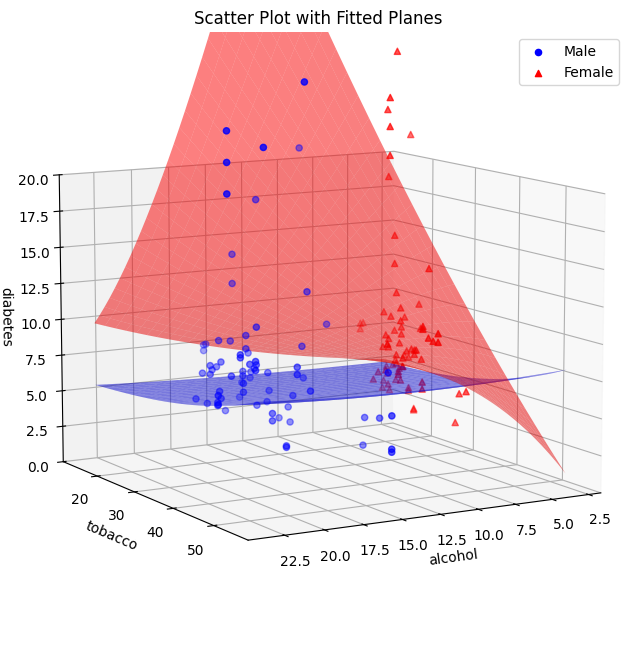


Test Results for tuberculosis:
	Mean Squared Error: 104.1788
	R^2: 0.1173



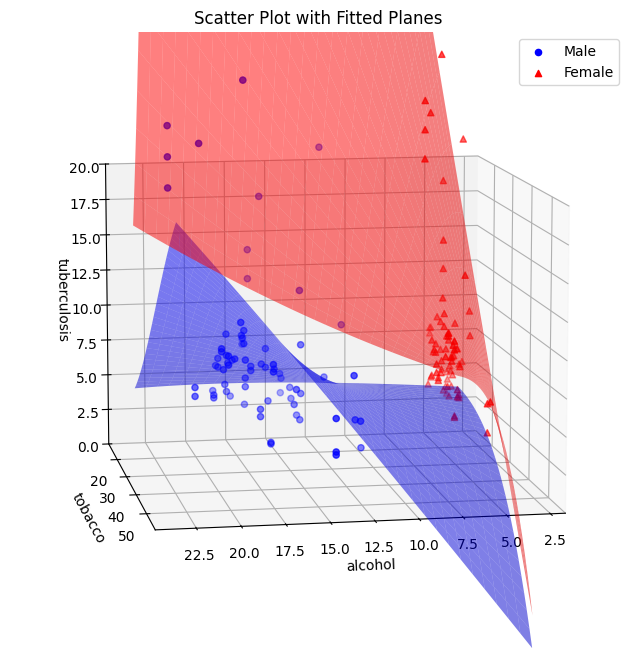

In [110]:
def plot_create_meshgrid(alcohol_range, tobacco_range, sex_value):
    alcohol_grid, tobacco_grid = np.meshgrid(alcohol_range, tobacco_range)
    sex_grid = np.full_like(alcohol_grid, sex_value)
    alcohol_sex_grid = alcohol_grid * sex_grid
    tobacco_sex_grid = tobacco_grid * sex_grid
    grid = pd.DataFrame({
        'alcohol': alcohol_grid.ravel(),
        'tobacco': tobacco_grid.ravel(),
        'sex': sex_grid.ravel(),
        'alcohol x sex': alcohol_sex_grid.ravel(),
        'tobacco x sex': tobacco_sex_grid.ravel()
    })
    return grid, alcohol_grid, tobacco_grid

def svr_process(y_name = 'diabetes', elev = 10, azim = 80, plot_dataset_source = 'test'):
    plot_dataset = dataset_test_mf if plot_dataset_source == 'test' else dataset_train_mf

    # Prepare data
    X_train = dataset_train_mf[['alcohol', 'tobacco', 'sex']].copy()
    X_train['alcohol x sex'] = X_train['alcohol'] * X_train['sex']
    X_train['tobacco x sex'] = X_train['tobacco'] * X_train['sex']

    X_test = dataset_test_mf[['alcohol', 'tobacco', 'sex']].copy()
    X_test['alcohol x sex'] = X_test['alcohol'] * X_train['sex']
    X_test['tobacco x sex'] = X_test['tobacco'] * X_train['sex']

    y_train = dataset_train_mf[y_name].copy()
    y_test = dataset_test_mf[y_name].copy()

    # Train
    svr_model = SVR(kernel = 'poly') # 'linear', 'poly', 'rbf', 'sigmoid', 'precomputed'
    svr_model.fit(X_train, y_train)

    # Test
    y_pred = svr_model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    print(f'\nTest Results for {y_name}:')
    print(f'\tMean Squared Error: {mse:.4f}') 
    print(f'\tR^2: {r2:.4f}\n')

    # 3D Plot
    fig = plt.figure(figsize=(10, 8))
    ax = fig.add_subplot(111, projection='3d')

    # Scatters
    sex0_data = plot_dataset[plot_dataset['sex'] == 0]
    ax.scatter(sex0_data['alcohol'], sex0_data['tobacco'], sex0_data['tuberculosis'], c = 'b', marker = 'o', label = 'Male')
    sex1_data = plot_dataset[plot_dataset['sex'] == 1]
    ax.scatter(sex1_data['alcohol'], sex1_data['tobacco'], sex1_data['tuberculosis'], c = 'r', marker = '^', label = 'Female')

    # Predicted Planes
    alcohol_range = np.linspace(plot_dataset['alcohol'].min(), plot_dataset['alcohol'].max(), 30)
    tobacco_range = np.linspace(plot_dataset['tobacco'].min(), plot_dataset['tobacco'].max(), 30)
    grid_male, alcohol_grid, tobacco_grid = plot_create_meshgrid(alcohol_range, tobacco_range, sex_value = 0)
    z_male = svr_model.predict(grid_male).reshape(alcohol_grid.shape)
    grid_female, _, _ = plot_create_meshgrid(alcohol_range, tobacco_range, sex_value = 1)
    z_female = svr_model.predict(grid_female).reshape(alcohol_grid.shape)

    # Plot the surfaces
    ax.plot_surface(alcohol_grid, tobacco_grid, z_male, color = 'blue', alpha = 0.5)
    ax.plot_surface(alcohol_grid, tobacco_grid, z_female, color = 'red', alpha = 0.5)

    # Labels and Legends
    ax.set_xlabel('alcohol')
    ax.set_ylabel('tobacco')
    ax.set_zlabel(y_name)
    ax.set_zlim([0, 20])
    ax.set_title('Scatter Plot with Fitted Planes')
    ax.legend()

    ax.view_init(elev = elev, azim = azim)

    plt.show()

svr_process('diabetes', elev = 10, azim = 60)
svr_process('tuberculosis', elev = 10, azim = 80)

### Multi-Layer Perceptron


Test Results for diabetes:
	Mean Squared Error: 2.6657
	R^2: 0.1287



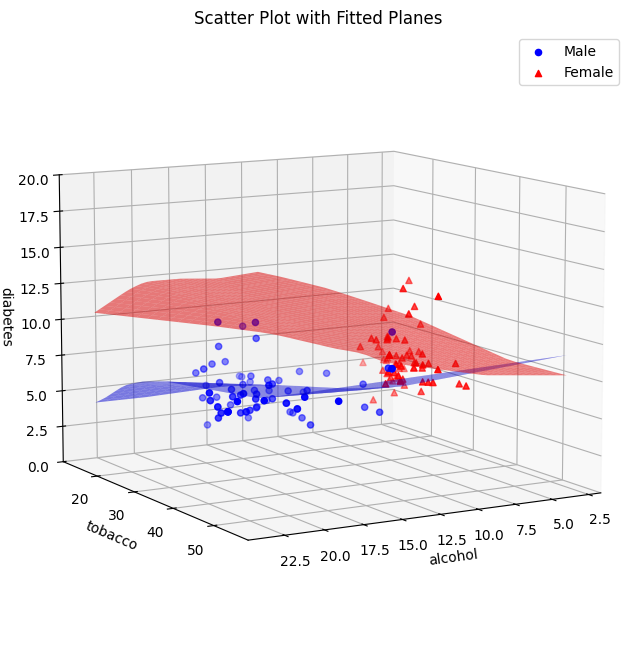


Test Results for tuberculosis:
	Mean Squared Error: 92.6423
	R^2: 0.2151



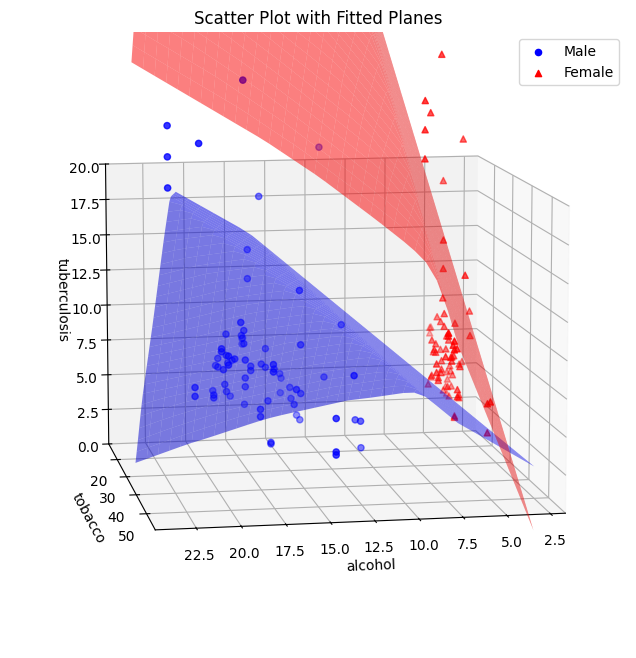

In [111]:
def mlp_process(y_name='diabetes', elev=10, azim=80, plot_dataset_source = 'test'):
    plot_dataset = dataset_test_mf if plot_dataset_source == 'test' else dataset_train_mf

    # Prepare data
    X_train = dataset_train_mf[['alcohol', 'tobacco', 'sex']].copy()
    X_train['alcohol x sex'] = X_train['alcohol'] * X_train['sex']
    X_train['tobacco x sex'] = X_train['tobacco'] * X_train['sex']

    X_test = dataset_test_mf[['alcohol', 'tobacco', 'sex']].copy()
    X_test['alcohol x sex'] = X_test['alcohol'] * X_test['sex']
    X_test['tobacco x sex'] = X_test['tobacco'] * X_test['sex']

    y_train = dataset_train_mf[y_name].copy()
    y_test = dataset_test_mf[y_name].copy()

    # Train
    mlp_model = MLPRegressor(hidden_layer_sizes=(50,), max_iter=1000, random_state=42)
    mlp_model.fit(X_train, y_train)

    # Test
    y_pred = mlp_model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    print(f'\nTest Results for {y_name}:')
    print(f'\tMean Squared Error: {mse:.4f}')
    print(f'\tR^2: {r2:.4f}\n')

    # 3D Plot
    fig = plt.figure(figsize=(10, 8))
    ax = fig.add_subplot(111, projection='3d')

    # Scatters
    sex0_data = plot_dataset[plot_dataset['sex'] == 0]
    ax.scatter(sex0_data['alcohol'], sex0_data['tobacco'], sex0_data[y_name], c = 'b', marker = 'o', label = 'Male')
    sex1_data = plot_dataset[plot_dataset['sex'] == 1]
    ax.scatter(sex1_data['alcohol'], sex1_data['tobacco'], sex1_data[y_name], c = 'r', marker = '^', label = 'Female')

    # Predicted Planes
    alcohol_range = np.linspace(plot_dataset['alcohol'].min(), plot_dataset['alcohol'].max(), 30)
    tobacco_range = np.linspace(plot_dataset['tobacco'].min(), plot_dataset['tobacco'].max(), 30)
    grid_male, alcohol_grid, tobacco_grid = plot_create_meshgrid(alcohol_range, tobacco_range, sex_value = 0)
    z_male = mlp_model.predict(grid_male).reshape(alcohol_grid.shape)
    grid_female, _, _ = plot_create_meshgrid(alcohol_range, tobacco_range, sex_value = 1)
    z_female = mlp_model.predict(grid_female).reshape(alcohol_grid.shape)

    # Plot the surfaces
    ax.plot_surface(alcohol_grid, tobacco_grid, z_male, color = 'blue', alpha = 0.5)
    ax.plot_surface(alcohol_grid, tobacco_grid, z_female, color = 'red', alpha = 0.5)

    # Labels and Legends
    ax.set_xlabel('alcohol')
    ax.set_ylabel('tobacco')
    ax.set_zlabel(y_name)
    ax.set_zlim([0, 20])
    ax.set_title('Scatter Plot with Fitted Planes')
    ax.legend()

    ax.view_init(elev = elev, azim = azim)

    plt.show()

mlp_process('diabetes', elev = 10, azim = 60)
mlp_process('tuberculosis', elev = 10, azim = 80)

### K-Nearest Neighbors


Test Results for diabetes:
	Mean Squared Error: 2.9963
	R^2: 0.0207



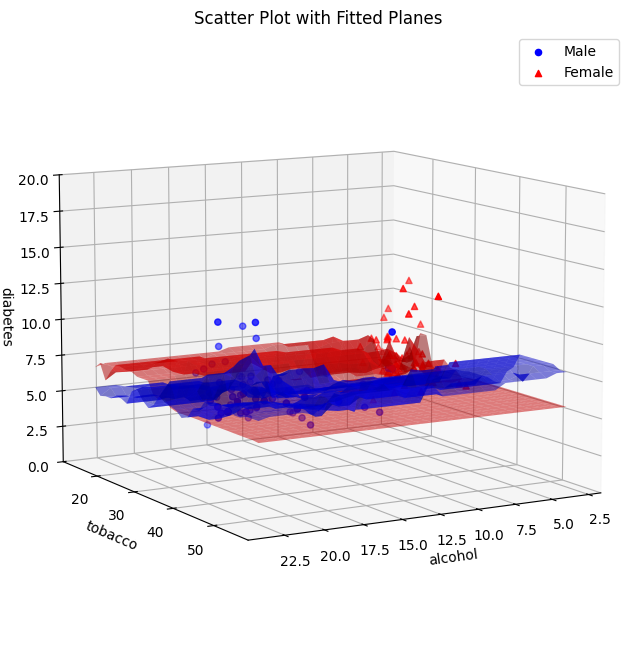


Test Results for tuberculosis:
	Mean Squared Error: 63.7354
	R^2: 0.4600



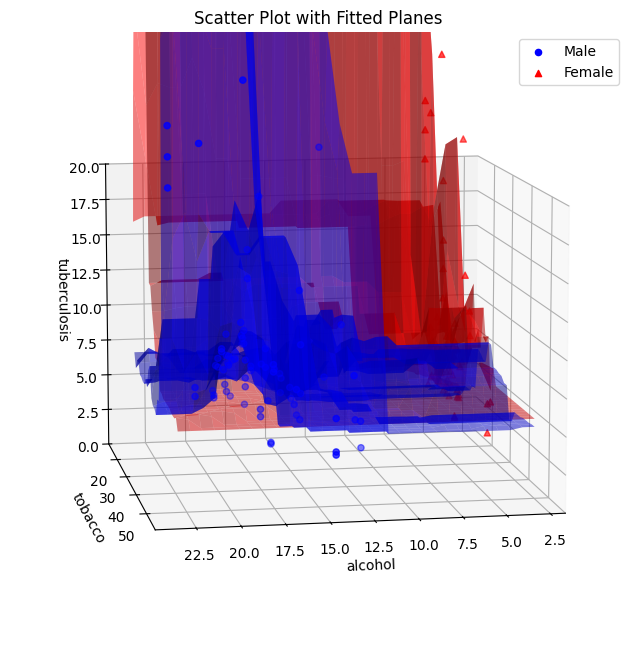

In [112]:
def knn_process(y_name='diabetes', k_neighbors = 5, elev=10, azim=80, plot_dataset_source='test'):
    plot_dataset = dataset_test_mf if plot_dataset_source == 'test' else dataset_train_mf

    # Prepare data
    X_train = dataset_train_mf[['alcohol', 'tobacco', 'sex']].copy()
    X_train['alcohol x sex'] = X_train['alcohol'] * X_train['sex']
    X_train['tobacco x sex'] = X_train['tobacco'] * X_train['sex']

    X_test = dataset_test_mf[['alcohol', 'tobacco', 'sex']].copy()
    X_test['alcohol x sex'] = X_test['alcohol'] * X_test['sex']
    X_test['tobacco x sex'] = X_test['tobacco'] * X_test['sex']

    y_train = dataset_train_mf[y_name].copy()
    y_test = dataset_test_mf[y_name].copy()

    # Train
    knn_model = KNeighborsRegressor(n_neighbors = k_neighbors)
    knn_model.fit(X_train, y_train)

    # Test
    y_pred = knn_model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    print(f'\nTest Results for {y_name}:')
    print(f'\tMean Squared Error: {mse:.4f}')
    print(f'\tR^2: {r2:.4f}\n')

    # 3D Plot
    fig = plt.figure(figsize = (10, 8))
    ax = fig.add_subplot(111, projection = '3d')

    # Scatters
    sex0_data = plot_dataset[plot_dataset['sex'] == 0]
    ax.scatter(sex0_data['alcohol'], sex0_data['tobacco'], sex0_data[y_name], c = 'b', marker = 'o', label = 'Male')
    sex1_data = plot_dataset[plot_dataset['sex'] == 1]
    ax.scatter(sex1_data['alcohol'], sex1_data['tobacco'], sex1_data[y_name], c = 'r', marker = '^', label = 'Female')

    # Predicted Planes
    alcohol_range = np.linspace(plot_dataset['alcohol'].min(), plot_dataset['alcohol'].max(), 30)
    tobacco_range = np.linspace(plot_dataset['tobacco'].min(), plot_dataset['tobacco'].max(), 30)
    grid_male, alcohol_grid, tobacco_grid = plot_create_meshgrid(alcohol_range, tobacco_range, sex_value = 0)
    z_male = knn_model.predict(grid_male).reshape(alcohol_grid.shape)
    grid_female, _, _ = plot_create_meshgrid(alcohol_range, tobacco_range, sex_value = 1)
    z_female = knn_model.predict(grid_female).reshape(alcohol_grid.shape)

    # Plot the surfaces
    ax.plot_surface(alcohol_grid, tobacco_grid, z_male, color = 'blue', alpha = 0.5)
    ax.plot_surface(alcohol_grid, tobacco_grid, z_female, color = 'red', alpha = 0.5)

    # Labels and Legends
    ax.set_xlabel('alcohol')
    ax.set_ylabel('tobacco')
    ax.set_zlabel(y_name)
    ax.set_zlim([0, 20])
    ax.set_title('Scatter Plot with Fitted Planes')
    ax.legend()

    ax.view_init(elev = elev, azim = azim)

    plt.show()

knn_process('diabetes', 10, elev = 10, azim = 60)
knn_process('tuberculosis', 10, elev = 10, azim = 80)